# Rossman dataset 

Fuente lightgbm: https://lightgbm.readthedocs.io/en/stable/

https://www.kaggle.com/competitions/rossmann-store-sales/data

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [25]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor, early_stopping, log_evaluation, LGBMClassifier
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ----------------------------
# CARGA Y PREPROCESAMIENTO
# ----------------------------
# Carga de datos
train = pd.read_csv('data/rossman.csv')
stores = pd.read_csv('data/store.csv')

# Merge de ambos datasets
df = pd.merge(train, stores, on='Store')

# Convertir la columna de fecha
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha para evitar leakage
df = df.sort_values('Date')

# Filtrar solo tiendas abiertas
df = df[df['Open'] == 1]

# ----------------------------
# FEATURE ENGINEERING
# ----------------------------

# Variables temporales útiles
df['month'] = df['Date'].dt.month
df['day_of_month'] = df['Date'].dt.day
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

# Eliminar columnas que no usaremos
df = df.drop(columns=['Date', 'Store', 'Customers', 'Open', 'Promo2'])



C:\Users\epile\AppData\Local\Temp\ipykernel_21216\4196977695.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/rossman.csv')


### ⚙️ Tuneando LightGBM

- **`num_iterations`** (`n_estimators` en `sklearn`):  
  Número total de árboles a entrenar. Si usas `early_stopping_rounds`, puedes poner un número alto sin preocuparte por overfitting.

- **`max_depth`**:  
  Profundidad máxima de cada árbol. Profundidades mayores capturan más complejidad, pero pueden sobreajustar.

- **`learning_rate`**:  
  Qué tan rápido aprende el modelo. Valores más bajos requieren más árboles, pero suelen generalizar mejor.

- **`subsample`** (`bagging_fraction`):  
  Fracción de observaciones usadas en cada árbol. Ayuda a reducir overfitting. Requiere activar también `bagging_freq`.

- **`feature_fraction`** (equivalente a `colsample_bytree` en XGBoost):  
  Fracción de columnas (features) usadas en cada árbol. También ayuda a evitar sobreajuste.

- **`early_stopping_rounds`**:  
  Detiene el entrenamiento si la métrica en el conjunto de validación no mejora en N iteraciones. Requiere `valid_sets` y `eval_metric`.

- **`metric`** (`eval_metric` en sklearn):  
  Métrica usada durante entrenamiento para monitorear desempeño (ej: `'rmse'`, `'mae'`, `'binary_logloss'`, `'auc'`).

- **`min_data_in_leaf`**:  
  Número mínimo de muestras requeridas en una hoja. Sirve para evitar sobreajuste. Similar a `min_child_samples` en XGBoost y `min_data_in_leaf` en CatBoost.

- **`lambda_l2`** (`reg_lambda` en sklearn):  
  Regularización L2 (Ridge) aplicada a los pesos de las hojas. Ayuda a controlar la complejidad.

- **`min_gain_to_split`** (`gamma` en XGBoost):  
  Ganancia mínima necesaria para hacer un split. Controla qué tan fácilmente el árbol se ramifica → útil contra overfitting.


    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]

## Conditional average treatment effect (CATE)

Para una covariable \( X = x \), el CATE se define como:

$$
\text{CATE}(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]
$$

> Es decir, **el efecto esperado del tratamiento para individuos con características \( X = x \)**.


# X-Learner: Estimación paso a paso

El **X-Learner** es un meta-learner diseñado para estimar efectos causales heterogéneos (CATEs) cuando el tratamiento es binario y el dataset está desbalanceado. A continuación, se presenta el procedimiento detallado:

---

## 1. Entrenar modelos por grupo (como un T-Learner)

Entrena dos modelos para predecir el resultado observado en cada grupo:

- $M_1(x) \approx \mathbb{E}[Y \mid X = x, T = 1]$  
- $M_0(x) \approx \mathbb{E}[Y \mid X = x, T = 0]$

---

## 2. Imputar efectos individuales contrafactuales

Aquí calculamos la diferencia entre el resultado observado y el resultado contrafactual estimado:

- Para individuos **tratados** ($T = 1$):  
  $$
  D^0_i = Y_i - M_0(X_i)
  $$

- Para individuos **no tratados** ($T = 0$):  
  $$
  D^1_i = M_1(X_i) - Y_i
  $$


---

## 3. Entrenar modelos para predecir efectos (CATE)

Entrena dos modelos adicionales:

- $\hat{\tau}_0(x)$ usando $\{X_i, D^0_i\}$ para individuos tratados  
- $\hat{\tau}_1(x)$ usando $\{X_i, D^1_i\}$ para individuos no tratados

Estos modelos aprenden a predecir el efecto causal condicional dentro de cada grupo.

---

## 4. Estimar el propensity score

Calcula la probabilidad de recibir tratamiento condicional a $X$:

$$
\hat{e}(x) = \mathbb{P}(T = 1 \mid X = x)
$$

Este propensity score puede ser estimado con regresión logística, boosting, etc.

---

## 5. Calcular el efecto causal final con ponderación

El estimador final combina las dos predicciones de CATE usando el propensity score:

$$
\hat{\tau}(x) = (1 - \hat{e}(x)) \cdot \hat{\tau}_0(x) + \hat{e}(x) \cdot \hat{\tau}_1(x)
$$

> Así se da más peso a la predicción que proviene del grupo opuesto al observado.

---

## ✅ Resumen

| Paso | Acción |
|------|--------|
| 1 | Estimar $M_0(x)$ y $M_1(x)$ como en T-Learner |
| 2 | Imputar efectos individuales con contrafactuales |
| 3 | Entrenar modelos $\hat{\tau}_0(x)$ y $\hat{\tau}_1(x)$ |
| 4 | Estimar $\hat{e}(x)$, el propensity score |
| 5 | Calcular $\hat{\tau}(x)$ con una combinación ponderada |

---

## Paso 1: T-learner


In [26]:
# ----------------------------
# SEPARACIÓN TEMPORAL: 80% pasado, 20% futuro
# ----------------------------
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separar X y y
target = 'Sales'
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]

# Guardar columna Promo antes de get_dummies
promo_train = X_train['Promo']
promo_test = X_test['Promo']

# Codificar variables categóricas
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Alinear columnas
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

# ----------------------------
# SEPARAR POR PROMO (entrenamiento y prueba)
# ----------------------------

# Detectar la columna codificada de Promo
promo_col = [col for col in X_train.columns if 'Promo' in col][0]  # asume binaria

# Train: Promo = 1
X_train_promo1 = X_train[X_train[promo_col] == 1]
y_train_promo1 = y_train.loc[X_train_promo1.index]

# Train: Promo = 0
X_train_promo0 = X_train[X_train[promo_col] == 0]
y_train_promo0 = y_train.loc[X_train_promo0.index]

# Test: Promo = 1
X_test_promo1 = X_test[X_test[promo_col] == 1]
y_test_promo1 = y_test.loc[X_test_promo1.index]

# Test: Promo = 0
X_test_promo0 = X_test[X_test[promo_col] == 0]
y_test_promo0 = y_test.loc[X_test_promo0.index]

# ----------------------------
# CREAR VECTORES BINARIOS DE TRATAMIENTO
# ----------------------------
y_train_promo = promo_train.reset_index(drop=True)
y_test_promo = promo_test.reset_index(drop=True)


In [27]:
# Definir modelo sin promo
m0 = LGBMRegressor()
m0.fit(X_train_promo0, y_train_promo0)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 374179, number of used features: 21
[LightGBM] [Info] Start training from score 5892.155073


LGBMRegressor()

In [28]:
# Definir modelo con promo
m1 = LGBMRegressor()
m1.fit(X_train_promo1, y_train_promo1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019269 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 301334, number of used features: 20
[LightGBM] [Info] Start training from score 8184.373154


LGBMRegressor()

# Parte 2

Entonces $D^0_i$ es una estimación del efecto causal individual para ese individuo, inferido desde el contrafactual no tratado.

In [29]:
# Imputar efectos individuales
# Para los tratados: Y observado menos predicción contrafactual (como si no hubieran sido tratados)
# Lo que pasó - lo que hubiese pasado sin tratamiento (sin promociones)
D0 = y_train_promo1 - m0.predict(X_train_promo1)

Entonces $D^1_i$ también es una estimación del efecto causal individual, pero desde el lado opuesto.

In [30]:
# Lo que habría pasado con tratamiento menos lo que pasó
D1 = m1.predict(X_train_promo0) - y_train_promo0

### Entrena los modelos

In [31]:
# Entrenar los modelos de efecto (CATEs)
# Usa tratados y sus efectos imputados
mD0 = LGBMRegressor()
mD0.fit(X_train_promo1, D0)

# Usa no tratados y sus efectos imputados
mD1 = LGBMRegressor()
mD1.fit(X_train_promo0, D1)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 443
[LightGBM] [Info] Number of data points in the train set: 301334, number of used features: 20
[LightGBM] [Info] Start training from score 2252.231600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 374179, number of used features: 21
[LightGBM] [Info] Start training from score 2134.320023


LGBMRegressor()

# Parte 4 : Propensity score

In [34]:
# Eliminar columna dummy de Promo para entrenar el modelo
X_train_ps = X_train.drop('Promo', axis=1)
X_test_ps = X_test.drop('Promo', axis=1)

# Entrenar modelo de Propensity Score
propensity_model = LGBMClassifier()
propensity_model.fit(X_train_ps, y_train_promo)

[LightGBM] [Info] Number of positive: 301334, number of negative: 374179
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 675513, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.446082 -> initscore=-0.216515
[LightGBM] [Info] Start training from score -0.216515


LGBMClassifier()

# Parte 5: Predecir 

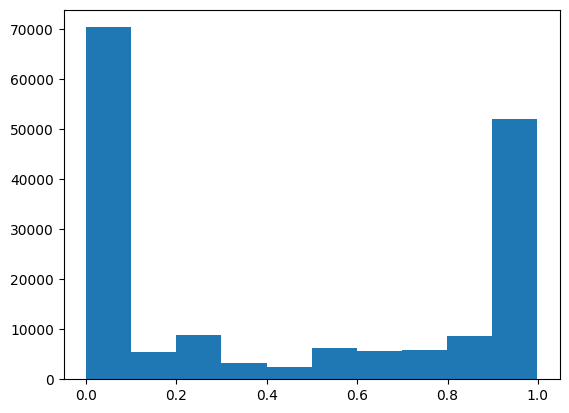

In [38]:
# Predice con tu X test 
propensity_score = propensity_model.predict_proba(X_test_ps)[:, 1]
plt.hist(propensity_score);

In [41]:
predict_d1 = mD1.predict(X_test)
predict_d0 = mD0.predict(X_test)

In [42]:
cate = propensity_score * predict_d1 + (1 - propensity_score) * predict_d0
cate

array([1633.71569655, 1881.45626686, 1398.15596509, ..., 1529.23123631,
        953.78494358, 1190.99152088])

Si la promo cuesta 1500, tendrías que ver cual sobre pasa el costo para ver si es rentable

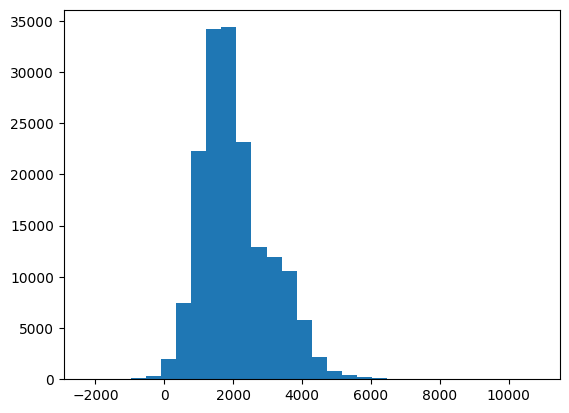

In [46]:
plt.hist(cate, bins=30);